In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0   # not gpu numbers
# how many samples per batch to load
batch_size = 50


use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu") 

# convert data to torch.FloatTensor



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])  # Note the brackets to define mean and std
])     

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True,  transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [3]:
train_data


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )

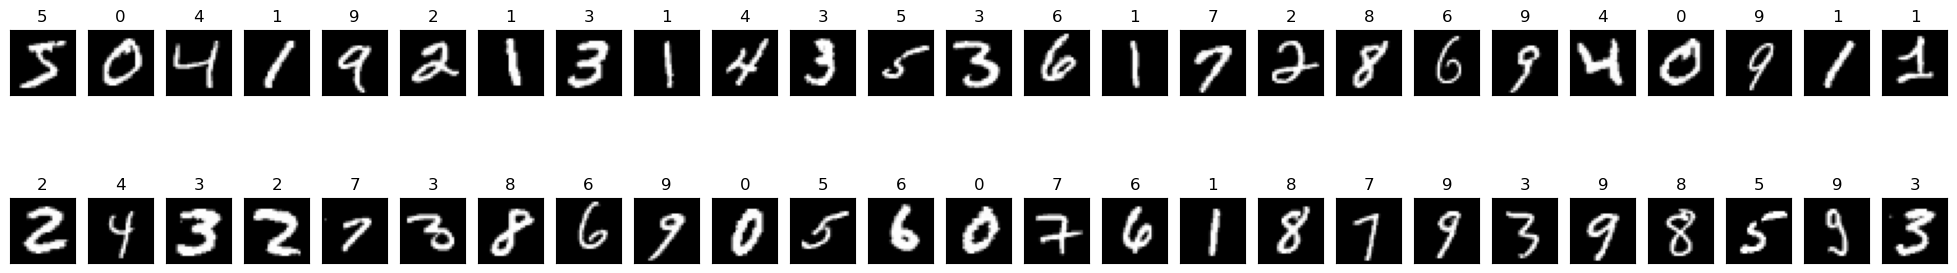

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(50):
    ax = fig.add_subplot(2, int(50/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


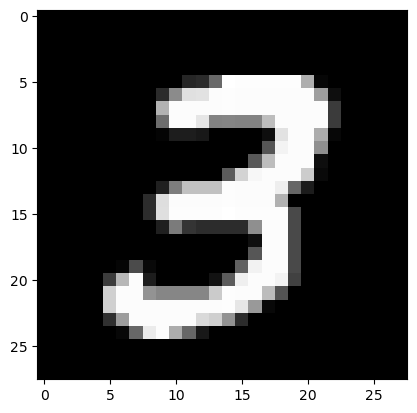

In [5]:
plt.imshow(images[7].reshape(28,28), cmap="gray")

In [6]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

model = Net().to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
print(images.reshape)
temp = images.reshape(-1, 28 * 28)  # 20*28*28 / (28*28)
print(temp.reshape)               # transforming the 2-D image to 1-D vector

<built-in method reshape of numpy.ndarray object at 0x7f0ccc54c8d0>
<built-in method reshape of numpy.ndarray object at 0x7f0cb3848d50>


In [8]:
print(model.fc1)
print(model.fc1.weight)



Linear(in_features=784, out_features=512, bias=True)
Parameter containing:
tensor([[-0.0034, -0.0128, -0.0067,  ...,  0.0012, -0.0148, -0.0134],
        [ 0.0042, -0.0131, -0.0328,  ...,  0.0288,  0.0286, -0.0171],
        [-0.0209,  0.0239,  0.0019,  ...,  0.0151,  0.0125, -0.0269],
        ...,
        [-0.0048, -0.0164, -0.0150,  ...,  0.0102,  0.0055,  0.0023],
        [ 0.0019, -0.0191,  0.0153,  ..., -0.0230,  0.0221, -0.0198],
        [-0.0323, -0.0066,  0.0270,  ..., -0.0012, -0.0237, -0.0327]],
       device='cuda:0', requires_grad=True)


In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
# per epoch, all the training data set is used once


model.train() # prep model for training


for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        data, target = data.to(device), target.to(device) # loading to GPU
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0) # as loss is tensor, .item() needed to get the value
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss)) ## printing command

Epoch: 1 	Training Loss: 1.034972
Epoch: 2 	Training Loss: 0.694409
Epoch: 3 	Training Loss: 0.646272
Epoch: 4 	Training Loss: 0.616726
Epoch: 5 	Training Loss: 0.595615
Epoch: 6 	Training Loss: 0.579487
Epoch: 7 	Training Loss: 0.566572
Epoch: 8 	Training Loss: 0.555963
Epoch: 9 	Training Loss: 0.546992
Epoch: 10 	Training Loss: 0.539184


In [10]:
print(f'Epoch: {epoch} \tTraining Loss: {train_loss}') ## printing command

Epoch: 9 	Training Loss: 0.5391838508099318


In [10]:
model.eval()  ## prepare for evaluation

test_loss = 0
correct = 0

with torch.no_grad():  # disabling the gradient calculation
    for data, target in test_loader:     ### using "test_loader" for evaluation
        data, target = data.to(device), target.to(device) # loading to GPU
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 9785/10000 (98%)



In [ ]:
print(output)  # Not clean one hot encoding, # no negative numbers
#print(output.size())

In [ ]:
print(output.size())
pred = output.argmax(dim=1, keepdim=True)
print(pred)

In [ ]:
print(pred.size())
print(target.size())
print(    target.view_as(pred).size()   )

In [ ]:
print(     pred.eq(   target.view_as(pred)  )             )
print(     pred.eq(target.view_as(pred)).sum().item()     )